In [91]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from enum import Enum

In [92]:
# ===========================
# 1️⃣ Define Enum for Skin Tones
# ===========================
class SkinTone(Enum):
    BLACK = 0
    BROWN = 1
    WHITE = 2

In [93]:
# ===========================
# 2️⃣ Load & Preprocess Dataset
# ===========================
def load_dataset(dataset_path, batch_size=32, img_size=(224, 224)):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='int'
    )

    # Store class names before applying transformations
    print("Class names:", dataset.class_names)

    # Normalize pixel values
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    # Data Augmentation Layer
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ])

    # Apply preprocessing
    dataset = dataset.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))

    return dataset

In [94]:
# ===========================
# 3️⃣ Split Dataset into Train & Validation Sets
# ===========================
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    return train_dataset, val_dataset

In [95]:
# ===========================
# 4️⃣ Build CNN Model
# ===========================
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(SkinTone), activation='softmax')  # Enum-based classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [96]:
# ===========================
# 5️⃣ Train the Model
# ===========================
def train_model(model, train_dataset, val_dataset, epochs=10):
    print("Training Model...")
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    return history

In [97]:
# ===========================
# 6️⃣ Save and Load Model
# ===========================
def save_model(model, model_path="skin_tone_model.h5"):
    model.save(model_path)
    print(f"Model saved at {model_path}")

def load_trained_model(model_path="skin_tone_model.h5"):
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")
    return model

In [98]:
# ===========================
# 7️⃣ Predict Skin Tone from an Image
# ===========================
def preprocess_image(image_path, img_size=(224, 224)):
    """Preprocess a single image for prediction"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)
    image = np.expand_dims(image / 255.0, axis=0)  # Normalize
    return image

def predict_skin_tone(image_path, model):
    image = extract_face_region(image_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)

    # Get Enum name based on predicted index
    predicted_skin_tone = SkinTone(predicted_class).name
    print(f"Predicted Skin Tone: {predicted_skin_tone}")

    # Show image
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_skin_tone}")
    plt.show()

def extract_face_region(image_path, img_size=(224, 224)):
    """Extracts face region from an image using OpenCV's Haar Cascade."""
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # Read image and convert to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    if len(faces) == 0:
        print("⚠️ No face detected! Using full image.")
        return preprocess_image(image_path, img_size)

    # Crop the first detected face
    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]

    # Resize and normalize
    face = cv2.resize(face, img_size)
    face = np.expand_dims(face / 255.0, axis=0)  # Normalize to (0-1)

    return face

In [99]:
# ===========================
# 7️⃣ Predict Skin Tone from an Image
# ===========================
def predict_skin_tone(image_path, model):
    image = extract_face_region(image_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)

    # Get Enum name based on predicted index
    predicted_skin_tone = SkinTone(predicted_class).name
    print(f"Predicted Skin Tone: {predicted_skin_tone}")

    # Show image
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_skin_tone}")
    plt.show()

Found 1500 files belonging to 3 classes.
Class names: ['black', 'brown', 'white']
Training Model...
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 607ms/step - accuracy: 0.3865 - loss: 1.9020 - val_accuracy: 0.3101 - val_loss: 1.7778
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 596ms/step - accuracy: 0.5271 - loss: 1.0086 - val_accuracy: 0.6297 - val_loss: 0.7563
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 603ms/step - accuracy: 0.6057 - loss: 0.8122 - val_accuracy: 0.6582 - val_loss: 0.6942
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 615ms/step - accuracy: 0.6657 - loss: 0.7260 - val_accuracy: 0.6677 - val_loss: 0.7327
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 680ms/step - accuracy: 0.7003 - loss: 0.6968 - val_accuracy: 0.6899 - val_loss: 0.7009
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 616ms/step - accuracy: 0.6991 - loss: 0.6686 - val_accuracy: 0.6741 - val_loss: 0.7059
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 629ms/step - accuracy: 0.7096 - loss: 0.6757 - val_accuracy: 0.6994 - val_loss: 0.69

Model saved at skin_tone_model.h5
Model loaded from skin_tone_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Skin Tone: BLACK


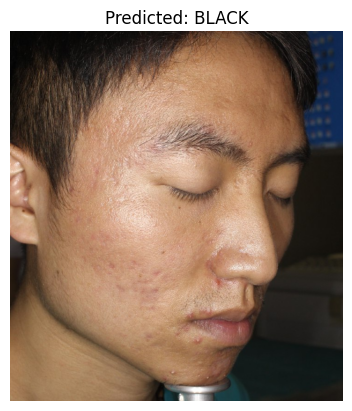

In [100]:
# ===========================
# 9️⃣ Main Execution
# ===========================
if __name__ == "__main__":
    dataset_path = "datasets/skin-tone/"  # Change this to your dataset path
    dataset = load_dataset(dataset_path)
    train_dataset, val_dataset = split_dataset(dataset)

    model = build_model()
    train_model(model, train_dataset, val_dataset)

    save_model(model)  # Save after training

    # Load model and test
    model = load_trained_model()
    predict_skin_tone("test_image.jpeg", model)

# if __name__ == "__main__":
#     # Load model and test
#     model = load_trained_model()
#     predict_skin_tone("test_image.jpeg", model)